# **Active learning comparison between the two models**

## **Preliminary steps**

In [ ]:
### PACKAGES

import torch

In [ ]:
### FUNCTIONS AND CLASSES

from src.libs import preprocessing, visualization, utils
from src.libs.tokenizer import ReversedPairingTokenizer
from src.model.transformer import MyTransformer


In [3]:
### DEVICE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


## **Tokenizer**

In [4]:
### CREATE TOKENIZER

tokenizer = ReversedPairingTokenizer()
VOCAB_SIZE = tokenizer.ntokens
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 114


## **Data**

In [5]:
### CONSTANTS

NUM_DIGITS = 3

TRAIN_SIZE = 600
VALID_SIZE = 100
TEST_SIZE = 1000

In [6]:
### CREATE DATASETS

train_dataset = preprocessing.create_dataset(
    nb_samples=TRAIN_SIZE, num_digits=NUM_DIGITS
)

valid_dataset = preprocessing.create_dataset(
    nb_samples=VALID_SIZE, num_digits=NUM_DIGITS
)

test_dataset = preprocessing.create_dataset(nb_samples=TEST_SIZE, num_digits=NUM_DIGITS)

## **MODELS**

In [7]:
### ARCHITECTURE

NB_LAYERS = 2
NB_HEADS = 8
EMBEDDING_DIMENSION = 64
HEAD_SIZE = 8  # EMBEDDING_DIMENSION // NB_HEADS
CONTEXT_LENGTH = 20
HIDDEN_DIMENSION = 8
DROPOUT_TRANSFORMER = 0.1
DROPOUT_BAYESFORMER = 0.3

In [8]:
### TRANSFORMER

transformer = MyTransformer(
    ntoken=VOCAB_SIZE,
    d_model=EMBEDDING_DIMENSION,
    n_heads=NB_HEADS,
    dim_feedforward=HIDDEN_DIMENSION,
    nlayers=NB_LAYERS,
    dropout=DROPOUT_TRANSFORMER,
).to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in transformer.parameters()])
    )
)

number of parameters: 50178


In [9]:
### BAYESFORMER

bayesformer = MyTransformer(
    ntoken=VOCAB_SIZE,
    d_model=EMBEDDING_DIMENSION,
    n_heads=NB_HEADS,
    dim_feedforward=HIDDEN_DIMENSION,
    nlayers=NB_LAYERS,
    bayes_dropout=DROPOUT_BAYESFORMER,
    bayes=True,
).to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in bayesformer.parameters()])
    )
)

number of parameters: 50178


## **TRAINING**

In [10]:
### CONSTANTS

NB_EPOCHS = 5
BATCH_SIZE = 20
LEARNING_RATE = 1e-3

assert (
    TRAIN_SIZE % BATCH_SIZE == 0
    and VALID_SIZE % BATCH_SIZE == 0
    and TEST_SIZE % BATCH_SIZE == 0
), "BATCH_SIZE must be a divisor of TRAIN_SIZE, VALID_SIZE and TEST_SIZE"

In [11]:
### TRAIN TRANSFORMER

train_losses_transformer, valid_losses_transformer = utils.train(
    model=transformer,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)

EPOCH [1 / 5] ----------- TRAIN LOSS : 0.1793, VALID LOSS : 0.125486
EPOCH [2 / 5] ----------- TRAIN LOSS : 0.1120, VALID LOSS : 0.099447
EPOCH [3 / 5] ----------- TRAIN LOSS : 0.0953, VALID LOSS : 0.085083
EPOCH [4 / 5] ----------- TRAIN LOSS : 0.0823, VALID LOSS : 0.077108
EPOCH [5 / 5] ----------- TRAIN LOSS : 0.0764, VALID LOSS : 0.073957
Best valid loss : 0.0740


In [12]:
### TRAIN BAYESFORMER

train_losses_bayesformer, valid_losses_bayesformer = utils.train(
    model=bayesformer,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)

EPOCH [1 / 5] ----------- TRAIN LOSS : 0.2125, VALID LOSS : 0.161932
EPOCH [2 / 5] ----------- TRAIN LOSS : 0.1383, VALID LOSS : 0.116038
EPOCH [3 / 5] ----------- TRAIN LOSS : 0.1094, VALID LOSS : 0.101291
EPOCH [4 / 5] ----------- TRAIN LOSS : 0.0988, VALID LOSS : 0.093376
EPOCH [5 / 5] ----------- TRAIN LOSS : 0.0920, VALID LOSS : 0.088013
Best valid loss : 0.0880


## **Plots**

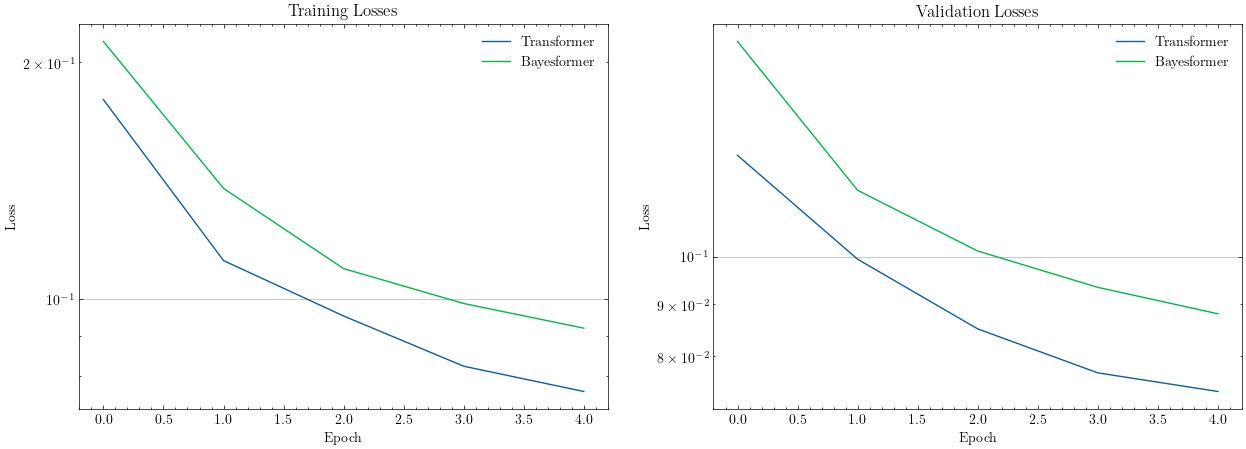

In [ ]:
visualization.plot_comparison_losses(
    [train_losses_transformer, train_losses_bayesformer],
    [valid_losses_transformer, valid_losses_bayesformer],
    ["Transformer", "Bayesformer"],
    True,
)

## **Evaluation**

In [14]:
### EVALUATE TRANSFORMER

accuracy_test_transformer = utils.evaluate(
    model=transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}")

### EXAMPLES

transformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = utils.generate(transformer, prompt_tensor, len(answers) + 1, DEVICE).view(
        (1, -1)
    )
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

Transformer accuracy on test set: 0.00
433+66=997<EOS>	 actual result: 499
143+380=1333	 actual result: 523
601+524=1113<EOS>	 actual result: 1125
313+184=1147	 actual result: 497
948+181=1333<EOS>	 actual result: 1129


In [15]:
### EVALUATE BAYESFORMER

accuracy_test_bayesformer = utils.evaluate(
    model=bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(f"Bayesformer accuracy on test set: {accuracy_test_bayesformer:.2f}")

### EXAMPLES

bayesformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = utils.generate(bayesformer, prompt_tensor, len(answers) + 1, DEVICE).view(
        (1, -1)
    )
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

Bayesformer accuracy on test set: 0.00
433+66=819<EOS>	 actual result: 499
143+380=113<EOS>	 actual result: 523
601+524=662<EOS><PAD>	 actual result: 1125
313+184=1170	 actual result: 497
948+181=129<EOS><PAD>	 actual result: 1129
